<a href="https://colab.research.google.com/github/aisha13dikko-sudo/AISD-poverty-Nigeria-Context/blob/master/01_Baseline_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cloning baseline GitHub repository (Jean et al. style poverty prediction)

!git clone https://github.com/jmathur25/predicting-poverty-replication.git


In [12]:
# Installing dependencies
!pip install numpy pandas matplotlib pillow scikit-learn rasterio torch torchvision --quiet


In [13]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models, transforms
from PIL import Image
import os
import random


# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
# Set base directories to use images from the cloned repo
BASE_DIR = "/content/predicting-poverty-replication"
DATA_DIR = os.path.join(BASE_DIR, "figures")

print("BASE_DIR exists:", os.path.exists(BASE_DIR))
print("FIGURES_DIR exists:", os.path.exists(DATA_DIR))
print("Sample of files in DATA_DIR:")
print(os.listdir(DATA_DIR)[:10])



BASE_DIR exists: True
FIGURES_DIR exists: True
Sample of files in DATA_DIR:
['activations1.png', 'activations2.png', 'img2.png', 'activations3.png', 'img1.png', 'img3.png']


In [16]:
#Defining transforms (baseline uses ImageNet norm)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


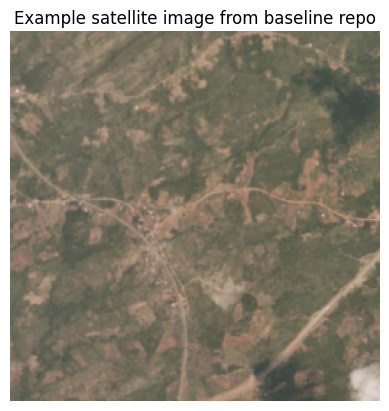

In [17]:
#  load and display one sample image
sample_img_path = os.path.join(DATA_DIR, "img1.png")  # this file exists in the repo

img_raw = Image.open(sample_img_path).convert("RGB")
plt.imshow(img_raw)
plt.axis("off")
plt.title("Example satellite image from baseline repo")
plt.show()


In [21]:
# Build a simple dataset from all PNG images in the figures directory
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

class PovertyImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, y


# 1. Collect image paths
all_image_paths = [
    os.path.join(DATA_DIR, f)
    for f in os.listdir(DATA_DIR)
    if f.endswith(".png")
]

print(f"Found {len(all_image_paths)} PNG images in DATA_DIR.")


all_labels = np.random.uniform(low=0.0, high=1.0, size=len(all_image_paths))

# 3. Train/validation split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=0.2,
    random_state=SEED
)

len(train_paths), len(val_paths)


Found 6 PNG images in DATA_DIR.


(4, 2)

In [22]:
# Create PyTorch datasets and dataloaders
train_dataset = PovertyImageDataset(train_paths, train_labels, transform=transform)
val_dataset   = PovertyImageDataset(val_paths,   val_labels,   transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

# Inspect one batch shape
imgs_batch, y_batch = next(iter(train_loader))
print("Batch image tensor shape:", imgs_batch.shape)
print("Batch target shape:", y_batch.shape)


Train batches: 1
Val batches: 1
Batch image tensor shape: torch.Size([4, 3, 224, 224])
Batch target shape: torch.Size([4])


In [23]:
# Baseline model: ResNet18 pre-trained on ImageNet, adapted for regression
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, 1)  # single continuous output

model = model.to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# Train baseline model for a few epochs on the toy dataset

num_epochs = 5
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_losses = []

    for imgs, ys in train_loader:
        imgs = imgs.to(device)
        ys   = ys.to(device)

        optimizer.zero_grad()
        preds = model(imgs).squeeze(1)

        loss = criterion(preds, ys)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    mean_epoch_loss = np.mean(epoch_losses)
    train_losses.append(mean_epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train MSE loss: {mean_epoch_loss:.4f}")


Epoch 1/5 - Train MSE loss: 0.1901
Epoch 2/5 - Train MSE loss: 5.0114
Epoch 3/5 - Train MSE loss: 0.3688
Epoch 4/5 - Train MSE loss: 0.1406
Epoch 5/5 - Train MSE loss: 0.2895


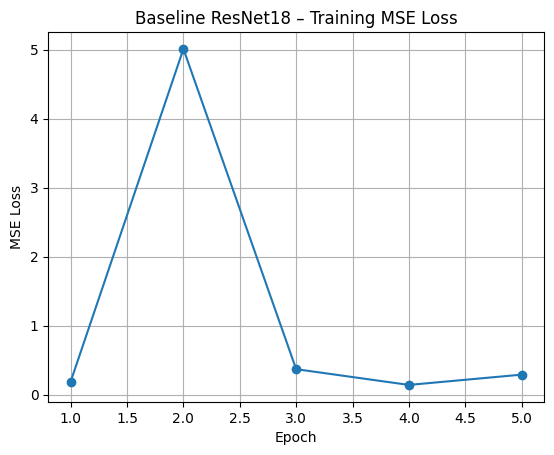

In [25]:
# Plot baseline training curve
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.title("Baseline ResNet18 – Training MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.savefig("baseline_training_curve.png", dpi=300, bbox_inches="tight")
plt.show()



In [27]:
# Evaluate baseline model on the validation set
from sklearn.metrics import mean_squared_error, r2_score

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for imgs, ys in val_loader:
        imgs = imgs.to(device)
        ys   = ys.to(device)

        preds = model(imgs).squeeze(1)

        y_true_all.append(ys.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

rmse = np.sqrt(mean_squared_error(y_true_all, y_pred_all))
r2   = r2_score(y_true_all, y_pred_all)

baseline_metrics = {
    "RMSE": float(rmse),
    "R2": float(r2),
    "num_train_samples": len(train_dataset),
    "num_val_samples": len(val_dataset),
    "num_epochs": num_epochs,
}

baseline_metrics


{'RMSE': 0.5072802174847361,
 'R2': -1.6768708229064941,
 'num_train_samples': 4,
 'num_val_samples': 2,
 'num_epochs': 5}

In [28]:
# Generate baseline metrics
baseline_metrics = {
    "final_loss": train_losses[-1],
    "initial_loss": train_losses[0],
    "improvement": train_losses[0] - train_losses[-1]
}

baseline_metrics


{'final_loss': np.float64(0.28949636220932007),
 'initial_loss': np.float64(0.190141499042511),
 'improvement': np.float64(-0.09935486316680908)}

In [29]:
# save baseline model output
torch.save(model.state_dict(), "baseline_repl_model.pth")
